In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from scipy import stats
from hloc.utils.read_write_model import read_images_binary, read_points3D_binary, read_cameras_binary

Fig.5 (a) Anchor (b) Positive image

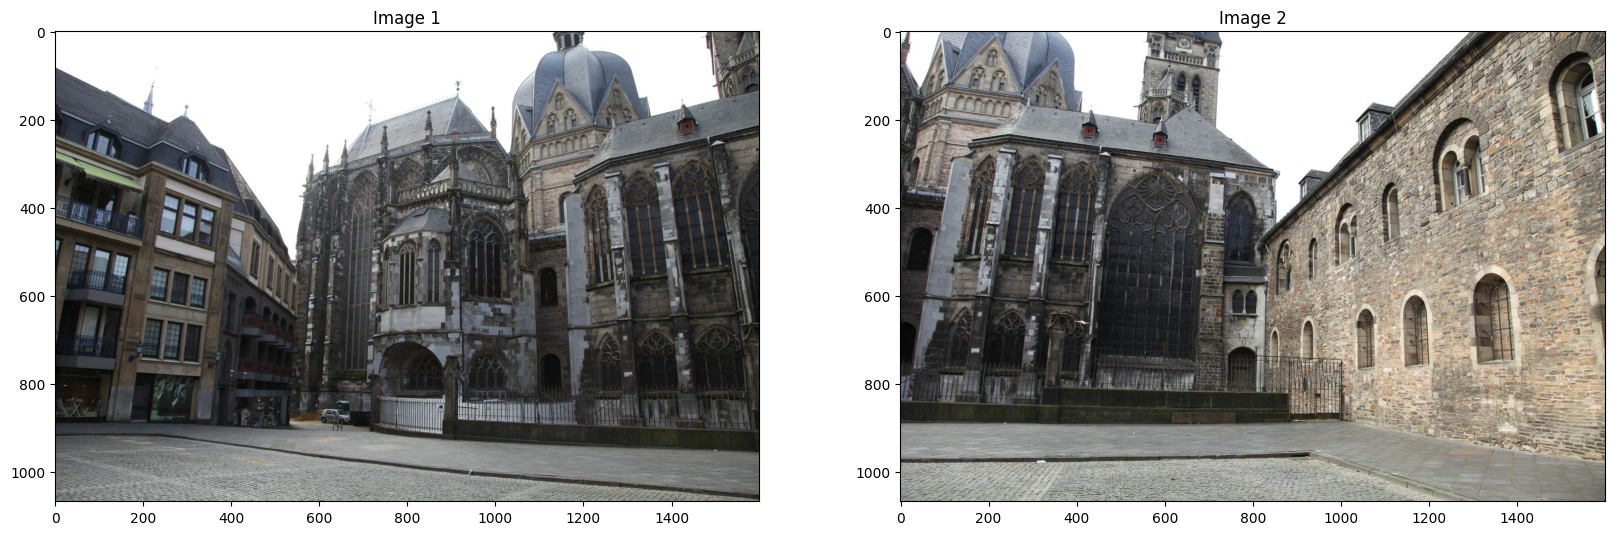

In [5]:
path = '/home/cvnar/Spatial_Contrastive_Loss/datasets/aachen/images/images_upright/'
image1 = cv2.imread(path+'db/1077.jpg')
image2 = cv2.imread(path+'db/1087.jpg')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.show()

In [2]:
def load_hloc_data(base_path):
    """Load HLOC data from given base path."""
    hloc_images = read_images_binary(f'{base_path}/images.bin')
    hloc_points3Ds = read_points3D_binary(f'{base_path}/points3D.bin')
    hloc_cameras = read_cameras_binary(f'{base_path}/cameras.bin')
    return hloc_images, hloc_points3Ds, hloc_cameras

def get_3d_points(hloc_images, hloc_points3Ds, image_key):
    """Extract 3D points for a given image key."""
    points = []
    id_3D = hloc_images[image_key].point3D_ids
    for k in id_3D:
        if k != -1:  # Skip if no 3D point
            points.append(hloc_points3Ds[k].xyz)
    return np.array(points)

def compute_3d_bbox(points):
    """Compute 3D bounding box from points."""
    min_values = np.min(points, axis=0)
    max_values = np.max(points, axis=0)
    return np.concatenate([min_values, max_values])

def plot_3d_bbox(bbox, ax, color='b'):
    """Plot 3D bounding box."""
    vertices = np.array([
        [bbox[0], bbox[1], bbox[2]],
        [bbox[0], bbox[1], bbox[5]],
        [bbox[0], bbox[4], bbox[2]],
        [bbox[0], bbox[4], bbox[5]],
        [bbox[3], bbox[1], bbox[2]],
        [bbox[3], bbox[1], bbox[5]],
        [bbox[3], bbox[4], bbox[2]],
        [bbox[3], bbox[4], bbox[5]]
    ])
    
    edges = [
        (0,1), (0,2), (0,4), (1,3), (1,5), (2,3),
        (2,6), (3,7), (4,5), (4,6), (5,7), (6,7)
    ]
    
    for edge in edges:
        ax.plot(*zip(vertices[edge[0]], vertices[edge[1]]), color=color)

def remove_outliers(points, threshold=3):
    """Remove outliers using z-score method."""
    df = pd.DataFrame(points, columns=['x', 'y', 'z'])
    z_scores = np.abs(stats.zscore(df))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask].values

In [3]:
base_path = '/home/cvnar/Spatial_Contrastive_Loss/outputs/aachen/sfm_superpoint+superglue'
hloc_images, hloc_points3Ds, hloc_cameras = load_hloc_data(base_path)

# Get points for two images
points88 = get_3d_points(hloc_images, hloc_points3Ds, 88)
points99 = get_3d_points(hloc_images, hloc_points3Ds, 99)
bbox1 = compute_3d_bbox(points88)
bbox2 = compute_3d_bbox(points99)

(c) Opverlapping 3D bounding boxes generated from the anchor, and positive image 3D points (green: anchor, blue: positive, red: overlap)

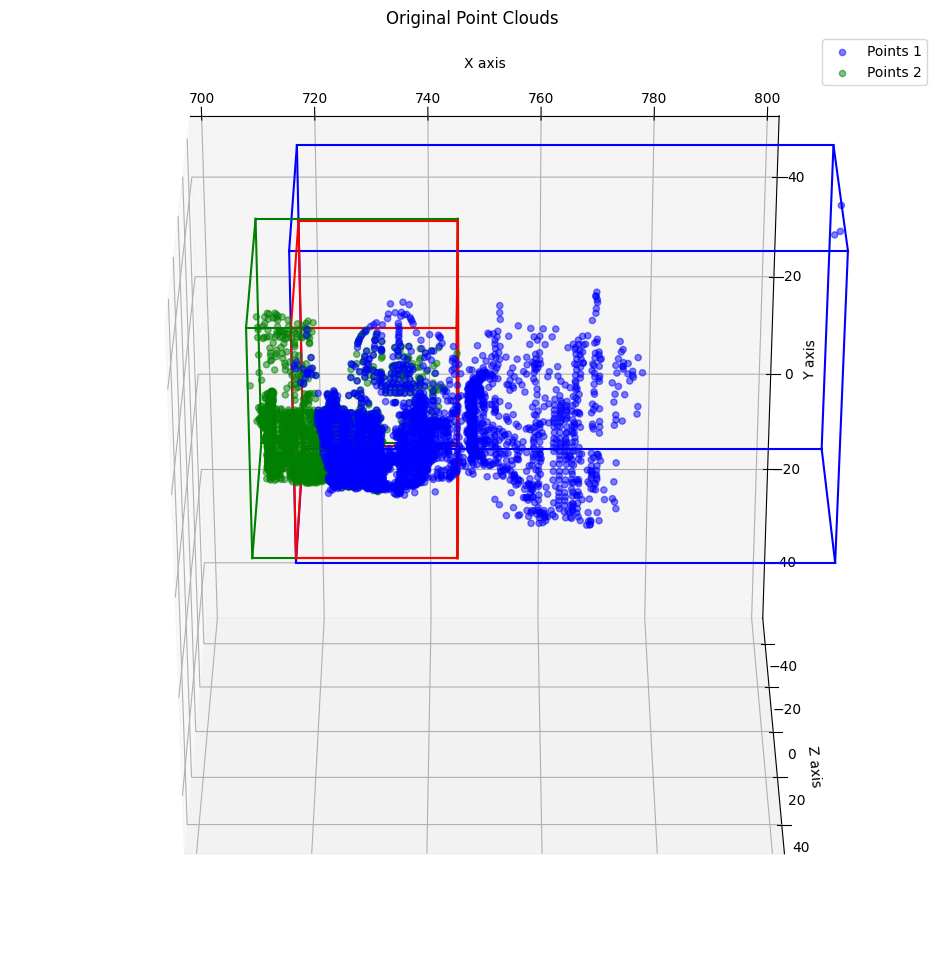

In [4]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(points88[:,0], points88[:,1], points88[:,2], c='blue', alpha=0.5, label='Points 1')
ax.scatter(points99[:,0], points99[:,1], points99[:,2], c='green', alpha=0.5, label='Points 2')

# Plot bounding boxes
plot_3d_bbox(bbox1, ax, 'blue')
plot_3d_bbox(bbox2, ax, 'green')

# Plot intersection if exists
intersection_bbox = [
    max(bbox1[0], bbox2[0]), max(bbox1[1], bbox2[1]), max(bbox1[2], bbox2[2]),
    min(bbox1[3], bbox2[3]), min(bbox1[4], bbox2[4]), min(bbox1[5], bbox2[5])
]
if all(intersection_bbox[i] < intersection_bbox[i+3] for i in range(3)):
    plot_3d_bbox(intersection_bbox, ax, 'red')

ax.view_init(elev=120, azim=-90)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title("Original Point Clouds")
ax.legend()
ax.set_xlim(700, 800)
ax.set_ylim(-50, 50)
ax.set_zlim(-50, 50)
plt.show()

(d) 3D bounding boxes generated from z-score normalization

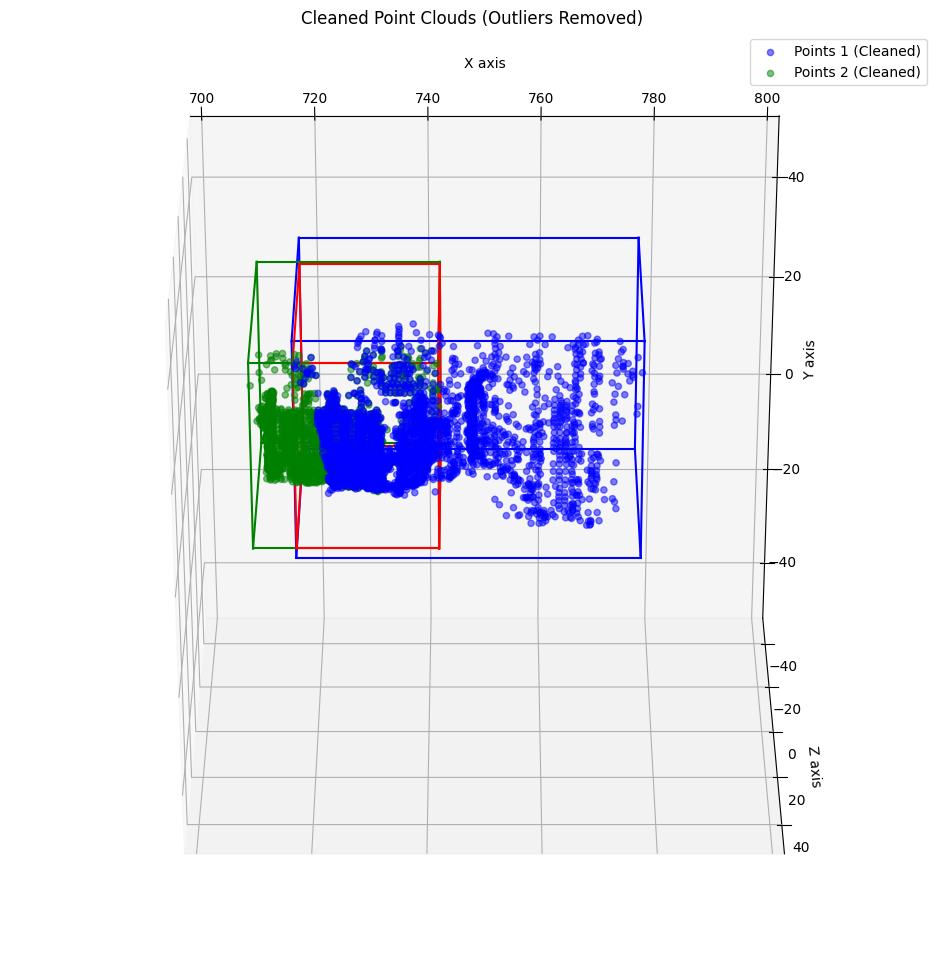

In [6]:
points88_clean = remove_outliers(points88)
points99_clean = remove_outliers(points99)
bbox1_clean = compute_3d_bbox(points88_clean)
bbox2_clean = compute_3d_bbox(points99_clean)

# Create visualization
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(points88_clean[:,0], points88_clean[:,1], points88_clean[:,2], 
          c='blue', alpha=0.5, label='Points 1 (Cleaned)')
ax.scatter(points99_clean[:,0], points99_clean[:,1], points99_clean[:,2], 
          c='green', alpha=0.5, label='Points 2 (Cleaned)')

# Plot bounding boxes
plot_3d_bbox(bbox1_clean, ax, 'blue')
plot_3d_bbox(bbox2_clean, ax, 'green')

# Plot intersection if exists
intersection_bbox = [
    max(bbox1_clean[0], bbox2_clean[0]), max(bbox1_clean[1], bbox2_clean[1]), max(bbox1_clean[2], bbox2_clean[2]),
    min(bbox1_clean[3], bbox2_clean[3]), min(bbox1_clean[4], bbox2_clean[4]), min(bbox1_clean[5], bbox2_clean[5])
]
if all(intersection_bbox[i] < intersection_bbox[i+3] for i in range(3)):
    plot_3d_bbox(intersection_bbox, ax, 'red')

ax.view_init(elev=120, azim=-90)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title("Cleaned Point Clouds (Outliers Removed)")
ax.legend()
ax.set_xlim(700, 800)
ax.set_ylim(-50, 50)
ax.set_zlim(-50, 50)
plt.show()